In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'

In [2]:
from utils import *

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

# path for dataset (will be not there after end of session)
path_data = "./data"
path_logs = "./logs"

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Dataloaders

In [5]:
BATCH_SIZE = 32
augment = False
random_seed = 1

train_loader, valid_loader = get_train_valid_loader(path_data,
                           BATCH_SIZE,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=1,
                           pin_memory=True)

dataloaders = {"train": train_loader, 
               "val": valid_loader}

test_loader = get_test_loader(path_data,
                    BATCH_SIZE,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Simple convolutional Net

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()

In [8]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [9]:
best_model, val_acc_history, plot_df = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25)

Epoch 0/24 	Train loss: 1.6098 acc: 0.4113 		 Val loss: 1.4670 acc: 0.4798
Epoch 1/24 	Train loss: 1.3277 acc: 0.5189 		 Val loss: 1.3467 acc: 0.5082
Epoch 2/24 	Train loss: 1.1862 acc: 0.5765 		 Val loss: 1.2185 acc: 0.5582
Epoch 3/24 	Train loss: 1.0881 acc: 0.6140 		 Val loss: 1.1137 acc: 0.5968
Epoch 4/24 	Train loss: 1.0157 acc: 0.6403 		 Val loss: 1.0747 acc: 0.6182
Epoch 5/24 	Train loss: 0.9545 acc: 0.6628 		 Val loss: 1.0429 acc: 0.6310
Epoch 6/24 	Train loss: 0.9033 acc: 0.6815 		 Val loss: 1.0578 acc: 0.6284
Epoch 7/24 	Train loss: 0.8605 acc: 0.6964 		 Val loss: 1.0470 acc: 0.6290
Epoch 8/24 	Train loss: 0.8243 acc: 0.7089 		 Val loss: 1.0325 acc: 0.6382
Epoch 9/24 	Train loss: 0.7952 acc: 0.7189 		 Val loss: 1.0100 acc: 0.6432
Epoch 10/24 	Train loss: 0.7600 acc: 0.7322 		 Val loss: 1.0369 acc: 0.6426
Epoch 11/24 	Train loss: 0.7312 acc: 0.7405 		 Val loss: 1.0709 acc: 0.6380
Epoch 12/24 	Train loss: 0.7031 acc: 0.7505 		 Val loss: 1.0697 acc: 0.6390
Epoch 13/24 	Train los

In [10]:
val_acc_history.head(3).append(val_acc_history.tail(3))

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.609771,0.411289,1.466973,0.4798
1,1,1.327660,0.518867,1.346695,0.5082
2,2,1.186246,0.576511,1.218510,0.5582
22,22,0.490173,0.823978,1.395623,0.6226
23,23,0.477502,0.829622,1.368230,0.6352
24,24,0.465025,0.833111,1.416223,0.6246


In [11]:
val_acc_history.to_csv(path_logs+"/EXP02.csv", index=None)

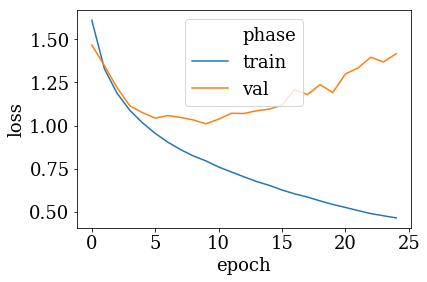

In [12]:
s = sns.lineplot(x='epoch', y='loss', data=plot_df, hue='phase')

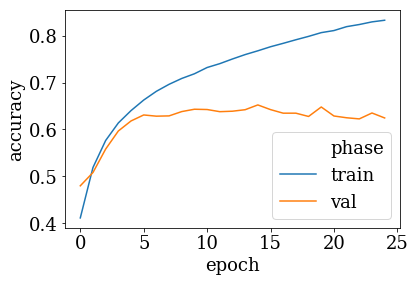

In [13]:
s = sns.lineplot(x='epoch', y='accuracy', data=plot_df, hue='phase')

In [14]:
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Accuracy of the network on the 10000 test images: 63.71 %


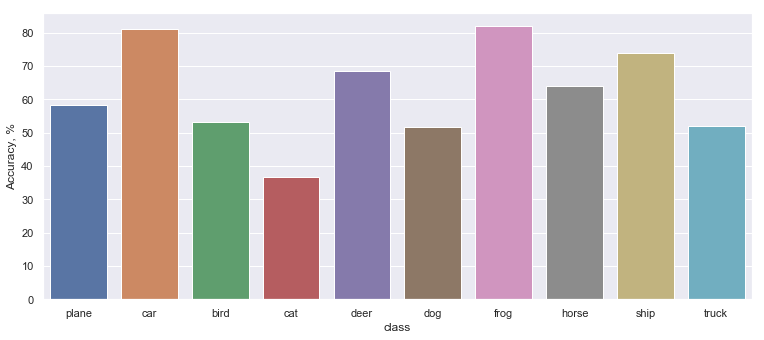

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images.to('cuda'))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cuda') == labels.to('cuda')).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images.to('cuda'))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.to('cuda') == labels.to('cuda')).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
acc_res_num = 100*np.array(class_correct) / np.array(class_total)
acc_res_df = pd.DataFrame({"class": classes, "Accuracy, %": acc_res_num})
sns.set(rc={'figure.figsize':(12.7,5.27)})
s = sns.barplot(x='class', y='Accuracy, %', data=acc_res_df)

In [16]:
acc_res = [str(round(v, 2))+"%" for v in acc_res_num]
acc_res_df_per = pd.DataFrame({"class": classes, "Accuracy, %": acc_res})
acc_res_df_per

,class,"Accuracy, %"
0,plane,58.33%
1,car,81.2%
2,bird,53.15%
3,cat,36.57%
4,deer,68.6%
5,dog,51.56%
6,frog,81.82%
7,horse,64.0%
8,ship,73.73%
9,truck,52.07%
